IMPORT MODULES

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

---

In [3]:
test_features = pd.read_csv('kc_house_data_test_features.csv', index_col=0)

In [4]:
training_data = pd.read_csv('kc_house_data_train.csv', index_col=0)

In [5]:
categorical = ['floors', 'waterfront', 'view', 'condition', 'grade', 'zipcode']
continuous = ['sqft_living', 'bedrooms', 'bathrooms', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
price = training_data['price']

In [6]:
#log of price
price = np.log(training_data['price'])

In [7]:
#numbers to measure against when getting RMSE or MSE

print('price min:', price.min())
print('price max:', price.max())
print('price mean:', price.mean())
print('price median:', price.median())

price min: 11.225243392518447
price max: 15.856730886823913
price mean: 13.048109095044126
price median: 13.017002861746503


In [8]:
cont_data = training_data[continuous]
cat_data = training_data[categorical]

---

In [9]:
cont_data.corr() 

,sqft_living,bedrooms,bathrooms,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15
sqft_living,1.000000,0.570428,0.755270,0.166810,0.876696,0.435529,0.755066,0.179570
bedrooms,0.570428,1.000000,0.507867,0.029375,0.472492,0.300085,0.387589,0.026665
bathrooms,0.755270,0.507867,1.000000,0.085470,0.686853,0.282700,0.568080,0.086499
sqft_lot,0.166810,0.029375,0.085470,1.000000,0.180755,0.008065,0.136959,0.701875
sqft_above,0.876696,0.472492,0.686853,0.180755,1.000000,-0.051199,0.731077,0.193874
sqft_basement,0.435529,0.300085,0.282700,0.008065,-0.051199,1.000000,0.199521,0.010007
sqft_living15,0.755066,0.387589,0.568080,0.136959,0.731077,0.199521,1.000000,0.178533
sqft_lot15,0.179570,0.026665,0.086499,0.701875,0.193874,0.010007,0.178533,1.000000


In [10]:
cat_data.corr() 

,floors,waterfront,view,condition,grade,zipcode
floors,1.000000,0.025132,0.025883,-0.259230,0.458984,-0.060560
waterfront,0.025132,1.000000,0.407565,0.009608,0.092234,0.034282
view,0.025883,0.407565,1.000000,0.045060,0.249554,0.089475
condition,-0.259230,0.009608,0.045060,1.000000,-0.142066,0.007068
grade,0.458984,0.092234,0.249554,-0.142066,1.000000,-0.184946
zipcode,-0.060560,0.034282,0.089475,0.007068,-0.184946,1.000000


In [11]:
#choosing 3 cont variables + 3 categorical vars
features = ['sqft_living', 'bedrooms', 'bathrooms', 'grade', 'waterfront', 'view']

In [12]:
#feature engineering

#if a house has 1 or more views, it's a 1 otherwise a 0
training_data['view_bin'] = np.where(training_data['view'].values >= 1, 1,0)
training_data['bedrooms'] = np.where((training_data.bedrooms > 6),6,training_data['bedrooms'])

In [13]:
# Continuous features to scale 
#living = training_data['sqft_living']
logliving = np.log(training_data['sqft_living'])
bed = training_data['bedrooms']
bath = training_data['bathrooms']

In [14]:
# Scale the features
scaler = StandardScaler()
#scaled_living = scaler.fit_transform(training_data[['sqft_living']])
scaled_livinglog = scaler.fit_transform(np.log(training_data[['sqft_living']]))
scaled_bed = scaler.fit_transform(training_data[['bedrooms']])
scaled_bath = scaler.fit_transform(training_data[['bathrooms']])

In [15]:
# Create a dataframe with scaled features
data_fin = pd.DataFrame([])
data_fin['living'] = scaled_livinglog.flatten()
data_fin['bed'] = scaled_bed.flatten()
data_fin['bath'] = scaled_bath.flatten()

In [16]:
# Create dummies for categorical features
grade_dummies = pd.get_dummies(training_data['grade'], prefix='grade', drop_first=True)
water = training_data['waterfront']
view = training_data['view_bin']

In [17]:
#drop the grade dummies with high p-values
grade_dummies.drop(columns=['grade_3','grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8'], inplace=True)

In [18]:
# Concat with dataframe 
data_fin = pd.concat([price, data_fin, grade_dummies, water, view], axis=1)

In [19]:
data_fin

,price,living,bed,bath,grade_9,grade_10,grade_11,grade_12,grade_13,waterfront,view_bin
0,12.807653,0.197942,0.710376,0.179189,0,0,0,0,0,0,0
1,13.670485,0.993220,1.831136,1.152641,0,0,0,0,0,0,0
2,13.852806,1.612070,0.710376,0.503673,0,0,1,0,0,0,1
3,14.214287,2.060815,-0.410383,1.801609,0,0,0,1,0,0,1
4,13.474428,0.689845,-0.410383,0.503673,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
17285,13.527828,1.254716,1.831136,0.503673,0,0,0,0,0,0,1
17286,12.994530,-0.899308,-1.531143,-0.469779,0,0,0,0,0,0,0
17287,12.644328,-1.403074,-0.410383,-1.443231,0,0,0,0,0,0,0
17288,12.965710,-0.004190,-0.410383,-0.794263,0,0,0,0,0,0,0


In [20]:
# Create model
outcome = 'price'
predictors = data_fin.drop('price', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=data_fin).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     2156.
Date:                Sat, 02 May 2020   Prob (F-statistic):               0.00
Time:                        15:17:24   Log-Likelihood:                -6451.4
No. Observations:               17290   AIC:                         1.292e+04
Df Residuals:                   17279   BIC:                         1.301e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.9530      0.003   3987.573      0.000      12.947      12.959
living         0.2467      0.005     48.575      0.000       0.237       0.257
bed           -0.0313      0.004     -8.785      0.000      -0.038      -0.024
bath           0.0260      0.004      6.203      0.000       0.018       0.034
grade_9        0.2660      0.009     28.817      0.000       0.248       0.284
grade_10       0.4285      0.014     31.608      0.000       0.402       0.455
grade_11       0.5778      0.022     26.806      0.000       0.536       0.620
grade_12       0.7687      0.043     17.842      0.000       0.684       0.853
grade_13       1.1736      0.107     10.958      0.000       0.964       1.383
waterfront     0.4403      0.031     14.025      0.000       0.379       0.502
view_bin       0.2266      0.010     23.634      0.000       0.208       0.245
==============================================================================
Omnibus:                       58.248   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.691
Skew:                           0.033   Prob(JB):                     1.20e-10
Kurtosis:                       2.757   Cond. No.                         60.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
# Test models

# Get a subset of the features and set to x and y

y = data_fin[['price']]
X = data_fin.drop(['price'], axis=1)

#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

# Pickle

Train Mean Squarred Error: price    0.124161
dtype: float64
Test Mean Squarred Error: price    0.120841
dtype: float64


In [32]:
np.exp(0.124161)

1.1321981402266852

In [22]:
## training the model with lasso

lasso = Lasso(alpha=0.01, normalize=False)

lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)

train_rmse = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )

Training Error: 0.30012162041683904
Testing Error: 0.3679871809653464


In [46]:
y_train

,price
2498,12.971308
10932,12.560244
15638,12.594731
15099,12.524526
15560,13.287878
...,...
11284,13.058358
11964,13.017003
5390,12.594731
860,13.036805


In [47]:
y_train_pred

array([13.21077137, 13.03742574, 12.31577565, ..., 12.88385734,
       13.04253469, 13.23095799])

In [45]:
np.exp(0.30012162041683904)

1.3500229879504948

In [41]:
np.exp(12.971308), np.exp(13.21077137)

(429900.0419219703, 546216.8679969818)

In [42]:
np.exp(13.21077137) - np.exp(12.971308)

116316.82607501152

In [48]:
np.exp(12.560244) - np.exp(13.03742574)

-174284.91438534192

In [27]:
#numbers to measure against when getting RMSE or MSE

print('price min:', price.min())
print('price max:', price.max())
print('price mean:', price.mean())
print('price median:', price.median())

price min: 11.225243392518447
price max: 15.856730886823913
price mean: 13.048109095044126
price median: 13.017002861746503


In [28]:
#normalizing using the difference between maximum and minimum: NRMSE=RMSEymax−ymin
print(train_rmse/(max(price)-min(price)))
print(test_rmse/(max(price)-min(price)))

0.0648002657431001
0.07945334655827015


In [29]:
#normalizing using the mean: NRMSE=RMSE¯
print(train_rmse/price.mean())
print(test_rmse/price.mean())

0.02300115811652969
0.02820233784718382


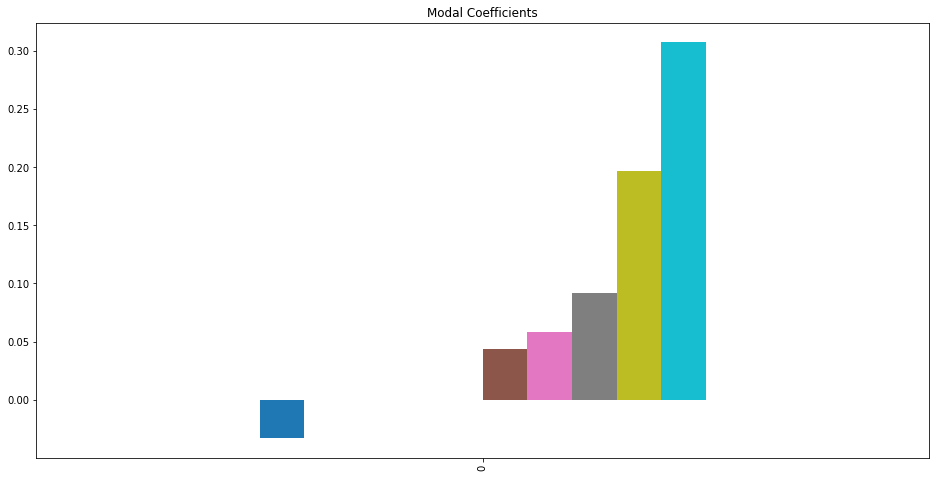

In [25]:
#displaying coefficients with lasso model

lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))

In [26]:
# checking for any coefficients that converge to 0

lasso_coef01.T

,0
bed,-0.032516
grade_11,0.000000
grade_12,0.000000
grade_13,0.000000
waterfront,0.000000
bath,0.043547
grade_9,0.058332
grade_10,0.092147
view_bin,0.196652
living,0.306990
